In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pipeline as pipe

warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', None)

# Data Import & Exploration

In [2]:
data = pd.read_pickle('data/pickle/final_dataset.pk1')

In [3]:
pipe.find_outliers(data, 'median_income', 0, 10000000)

Number of outliers found: 0
Outlier values found: []


,name,total_pop,median_income,state,county,county_name,state_name,prop_white,prop_black,prop_hisp,log_med_income,prop_no_internet,prop_ba,prop_services,pop_density,FIPS,covid_cases,Testing_Rate,gov_party,election_diff,Apr-19,Mar-19,Feb-20,Mar-20,Apr-20,days_closed,yearly_change,monthly_change


In [4]:
data.head()

,name,total_pop,median_income,state,county,county_name,state_name,prop_white,prop_black,prop_hisp,log_med_income,prop_no_internet,prop_ba,prop_services,pop_density,FIPS,covid_cases,Testing_Rate,gov_party,election_diff,Apr-19,Mar-19,Feb-20,Mar-20,Apr-20,days_closed,yearly_change,monthly_change
0,"Washington County, Mississippi",47086,30834.0,28,151,Washington,Mississippi,0.256913,0.721701,0.015482,10.336373,0.336958,0.187937,0.100274,62.178441,28151.0,77,2291.374085,1,-0.364695,6.4,7.5,7.4,6.6,15.4,17.0,1.406250,1.081081
1,"Perry County, Mississippi",12028,39007.0,28,111,Perry,Mississippi,0.787745,0.196874,0.015048,10.571496,0.310103,0.109539,0.078850,18.434583,28111.0,27,2291.374085,1,0.536635,5.7,6.2,6.8,6.0,12.5,17.0,1.192982,0.838235
2,"Choctaw County, Mississippi",8321,37203.0,28,019,Choctaw,Mississippi,0.676722,0.311982,0.003966,10.524145,0.368837,0.176582,0.014207,19.794546,28019.0,13,2291.374085,1,0.386224,4.8,5.3,5.4,4.9,9.8,17.0,1.041667,0.814815
3,"Itawamba County, Mississippi",23480,40510.0,28,057,Itawamba,Mississippi,0.909114,0.071593,0.015332,10.609304,0.226281,0.134468,0.057524,44.138916,28057.0,57,2291.374085,1,0.755161,4.1,4.4,4.7,4.2,21.4,17.0,4.219512,3.553191
4,"Carroll County, Mississippi",10129,43060.0,28,015,Carroll,Mississippi,0.643992,0.345839,0.002863,10.670350,0.332969,0.145006,0.057415,15.774563,28015.0,38,2291.374085,1,0.383321,5.5,5.8,6.2,5.7,13.2,17.0,1.400000,1.129032


In [5]:
pipe.get_summary_stats(data)

          total_pop  median_income   prop_white   prop_black    prop_hisp  \
count  2.826000e+03    2825.000000  2826.000000  2826.000000  2826.000000   
mean   1.117590e+05   51714.241416     0.827329     0.098748     0.091962   
std    3.414925e+05   13821.224638     0.164131     0.149708     0.135249   
min    4.180000e+02   20188.000000     0.093534     0.000000     0.000000   
25%    1.412200e+04   42491.000000     0.757614     0.008110     0.021500   
50%    3.013550e+04   49936.000000     0.889050     0.028182     0.041568   
75%    7.725500e+04   57886.000000     0.947572     0.117748     0.095686   
max    1.009805e+07  136268.000000     0.997743     0.874123     0.990688   

       log_med_income  prop_no_internet      prop_ba  prop_services  \
count     2825.000000       2826.000000  2826.000000    2825.000000   
mean        10.821023          0.225514     0.217787       0.083571   
std          0.251809          0.086132     0.096556       0.034479   
min          9.912844 

After reviewing the summary statistics, we confirmed that the median income is non-negative. We also looked into the potential outlier on population density and confirmed that that value is New York City.

In [6]:
data.dtypes

name                 object
total_pop             int64
median_income       float64
state                object
county               object
county_name          object
state_name           object
prop_white          float64
prop_black          float64
prop_hisp           float64
log_med_income      float64
prop_no_internet    float64
prop_ba             float64
prop_services       float64
pop_density         float64
FIPS                float64
covid_cases           int64
Testing_Rate        float64
gov_party             int64
election_diff       float64
Apr-19              float64
Mar-19              float64
Feb-20              float64
Mar-20              float64
Apr-20              float64
days_closed         float64
yearly_change       float64
monthly_change      float64
dtype: object

# Model Fitting & Evaluation

In [7]:
best_models = {}

## Monthly Data

### With States

In [8]:
# Select variables from full dataframe
df_mo_st = data.drop(['Apr-19', 'Mar-19', 'Feb-20', 'Mar-20', 'Apr-20', 'median_income',
                  'yearly_change', 'FIPS', 'name', 'state_name', 'county_name', 'county', 'total_pop'], axis=1)

In [9]:
# One-hot encode state
df_mo_st = pipe.hot_encode(df_mo_st, ['state'])

# Create training and testing sets
train, test = pipe.split_data(df_mo_st)

# Impute/nomralize continuous variables
numeric_cols = train.select_dtypes(include=['float64']).columns
train, test = pipe.impute_missing(train, test, numeric_cols)
train, test = pipe.normalize(train, test, numeric_cols)

# Separate features and targets
train_features = train.drop('monthly_change', axis=1)
test_features = test.drop('monthly_change', axis=1)

train_target = train['monthly_change']
test_target = test['monthly_change']

Training set contains 2260 observations
Testing set contains 566 observation

Imputing log_med_income missing values with median 10.819318178577827
Imputing prop_services missing values with median 0.0790869921304704


### Ridge

In [10]:
# Set up Pipeline for Ridge
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge(alpha=0.1))
])

alpha_range = np.arange(0.1, 1.1, 0.1)
params = {
          'ridge__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.0s finished


,param_ridge__alpha,param_poly__degree,rank_test_score,mean_test_score
9,1,1,1,-0.437192
8,0.9,1,2,-0.437338
7,0.8,1,3,-0.437531
6,0.7,1,4,-0.437779
5,0.6,1,5,-0.438093
4,0.5,1,6,-0.438485
3,0.4,1,7,-0.438974
2,0.3,1,8,-0.439582
1,0.2,1,9,-0.440339
0,0.1,1,10,-0.441287


In [11]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['state_ridge'] = d

# Rate coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('ridge', Ridge())]) 

Mean Squared Error: 0.4581674888339506
R-Squared: 0.5962437831789185
Adjusted R-Squared: 0.5446661427067643


,feature,coefficient,coefficient (absolute)
24,state_15,2.3227,2.322704
35,state_26,1.63933,1.639333
19,state_09,-1.44553,1.445529
33,state_24,-1.26016,1.260158
13,state_01,1.20212,1.202118
...,...,...,...
9,Testing_Rate,-0.0259175,0.025917
29,state_20,-0.0240517,0.024052
7,pop_density,0.00493767,0.004938
8,covid_cases,2.71714e-06,0.000003


### Lasso

In [12]:
# Lasso
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lasso', Lasso(alpha=0.1))
])

params = {
          'lasso__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


,param_lasso__alpha,param_poly__degree,rank_test_score,mean_test_score
0,0.1,1,1,-0.807805
2,0.2,1,2,-0.897193
4,0.3,1,3,-0.992735
18,1,1,4,-1.029193
16,0.9,1,5,-1.029230
14,0.8,1,6,-1.029268
12,0.7,1,7,-1.029305
10,0.6,1,8,-1.029343
8,0.5,1,9,-1.029380
6,0.4,1,10,-1.029418


In [13]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['state_lasso'] = d

# Rank coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('lasso', Lasso(alpha=0.1))]) 

Mean Squared Error: 0.8966014576504122
R-Squared: 0.20987756364267696
Adjusted R-Squared: 0.10894375939743006


,feature,coefficient,coefficient (absolute)
6,prop_services,0.168808,0.168808
3,log_med_income,0.120469,0.120469
4,prop_no_internet,-0.10139,0.101390
12,days_closed,0.0883304,0.088330
2,prop_hisp,-0.00652088,0.006521
...,...,...,...
29,state_20,-0,0.000000
30,state_21,0,0.000000
31,state_22,-0,0.000000
1,prop_black,-0,0.000000


### Linear Regression

In [14]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)), ('linreg', LinearRegression())
])

params = {
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished


,param_poly__degree,rank_test_score,mean_test_score
0,1,1,-0.442483
1,2,2,-8.496787


In [15]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['state_linear'] = d

# Rank coefficients
best_coeffs = pipe.rank_coefs(grid_model_result, train_features.columns) # Saved since this is best estimator
best_coeffs

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('linreg', LinearRegression())]) 

Mean Squared Error: 0.4512106420048186
R-Squared: 0.6023744454916956
Adjusted R-Squared: 0.5515799634786587


,feature,coefficient,coefficient (absolute)
24,state_15,3.18163,3.181628e+00
19,state_09,-1.68353,1.683529e+00
35,state_26,1.67514,1.675139e+00
21,state_11,-1.46944,1.469441e+00
33,state_24,-1.35891,1.358911e+00
...,...,...,...
9,Testing_Rate,-0.0311228,3.112283e-02
29,state_20,-0.0208026,2.080257e-02
7,pop_density,0.0116991,1.169912e-02
8,covid_cases,1.60689e-06,1.606885e-06


### Elastic Net

In [16]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)), ('en',ElasticNet())
])

params = {'en__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


,param_en__alpha,param_poly__degree,rank_test_score,mean_test_score
0,0.1,1,1,-0.775850
2,0.2,1,2,-0.815000
4,0.3,1,3,-0.855420
6,0.4,1,4,-0.905522
5,0.3,2,5,-0.952533
8,0.5,1,6,-0.956973
10,0.6,1,7,-1.000067
1,0.1,2,8,-1.004141
12,0.7,1,9,-1.026705
18,1,1,10,-1.029380


In [17]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['state_en'] = d

# Rank coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('en', ElasticNet(alpha=0.1))]) 

Mean Squared Error: 0.8623761954443013
R-Squared: 0.24003828592181076
Adjusted R-Squared: 0.1429573483948564


,feature,coefficient,coefficient (absolute)
6,prop_services,0.201362,0.201362
3,log_med_income,0.157768,0.157768
12,days_closed,0.126484,0.126484
4,prop_no_internet,-0.100896,0.100896
2,prop_hisp,-0.0649498,0.064950
...,...,...,...
30,state_21,0,0.000000
31,state_22,-0,0.000000
1,prop_black,-0,0.000000
33,state_24,-0,0.000000


### Without States

In [18]:
# Select variables from full dataframe
df_mo = data.drop(['Apr-19', 'Mar-19', 'Feb-20', 'Mar-20', 'Apr-20', 'median_income',
                  'yearly_change', 'FIPS', 'name', 'state_name', 'county_name', 'county', 'state', 'total_pop'], axis=1)

In [19]:
# Create training and testing sets
train, test = pipe.split_data(df_mo)

# Impute/normalize continuous variables
numeric_cols = train.select_dtypes(include=['float64']).columns #Normalizes state one-hots as well
train, test = pipe.impute_missing(train, test, numeric_cols)
train, test = pipe.normalize(train, test, numeric_cols)

# Separate features and targets                              
train_features = train.drop('monthly_change', axis=1)
test_features = test.drop('monthly_change', axis=1)

train_target = train['monthly_change']
test_target = test['monthly_change']

Training set contains 2260 observations
Testing set contains 566 observation

Imputing log_med_income missing values with median 10.819318178577827
Imputing prop_services missing values with median 0.0790869921304704


### Ridge

In [20]:
# Set up Pipeline for Ridge
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge(alpha=0.1))
])

params = {
          'ridge__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


,param_ridge__alpha,param_poly__degree,rank_test_score,mean_test_score
9,1,1,1,-0.733730
8,0.9,1,2,-0.733732
7,0.8,1,3,-0.733735
6,0.7,1,4,-0.733737
5,0.6,1,5,-0.733740
4,0.5,1,6,-0.733743
3,0.4,1,7,-0.733745
2,0.3,1,8,-0.733748
1,0.2,1,9,-0.733751
0,0.1,1,10,-0.733753


In [21]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['ridge'] = d

# Rank coefficients
best_coeffs_wo = pipe.rank_coefs(grid_model_result, train_features.columns)
best_coeffs_wo

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('ridge', Ridge())]) 

Mean Squared Error: 0.8151970933482989
R-Squared: 0.2816144698273457
Adjusted R-Squared: 0.26469597002255496


,feature,coefficient,coefficient (absolute)
10,gov_party,0.442755,0.442755
6,prop_services,0.265095,0.265095
3,log_med_income,0.258539,0.258539
12,days_closed,0.246906,0.246906
2,prop_hisp,-0.175531,0.175531
11,election_diff,-0.164669,0.164669
5,prop_ba,-0.0796003,0.079600
4,prop_no_internet,-0.0756287,0.075629
0,prop_white,0.058538,0.058538
7,pop_density,0.0394822,0.039482


### Lasso

In [22]:
# Lasso
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lasso', Lasso(alpha=0.1))
])

params = {
          'lasso__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished


,param_lasso__alpha,param_poly__degree,rank_test_score,mean_test_score
0,0.1,1,1,-0.807805
2,0.2,1,2,-0.897193
1,0.1,2,3,-0.953998
4,0.3,1,4,-0.992735
18,1,1,5,-1.029193
16,0.9,1,6,-1.029230
14,0.8,1,7,-1.029268
12,0.7,1,8,-1.029305
10,0.6,1,9,-1.029343
8,0.5,1,10,-1.029380


In [23]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['lasso'] = d

# Rank coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('lasso', Lasso(alpha=0.1))]) 

Mean Squared Error: 0.8966014576504122
R-Squared: 0.20987756364267696
Adjusted R-Squared: 0.19126960771397195


,feature,coefficient,coefficient (absolute)
6,prop_services,0.168808,0.168808
3,log_med_income,0.120469,0.120469
4,prop_no_internet,-0.10139,0.101390
12,days_closed,0.0883304,0.088330
2,prop_hisp,-0.00652088,0.006521
8,covid_cases,4.53039e-06,0.000005
0,prop_white,0,0.000000
1,prop_black,-0,0.000000
5,prop_ba,0,0.000000
7,pop_density,0,0.000000


### Linear Regression

In [24]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)), ('linreg', LinearRegression())
])

params = {
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


,param_poly__degree,rank_test_score,mean_test_score
0,1,1,-0.733756
1,2,2,-2.277979


In [25]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['linear'] = d

# Rank coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('linreg', LinearRegression())]) 

Mean Squared Error: 0.8152322752388684
R-Squared: 0.2815834660844282
Adjusted R-Squared: 0.26466423611902523


,feature,coefficient,coefficient (absolute)
10,gov_party,0.444128,0.444128
6,prop_services,0.265312,0.265312
3,log_med_income,0.259043,0.259043
12,days_closed,0.247242,0.247242
2,prop_hisp,-0.17579,0.175790
11,election_diff,-0.165104,0.165104
5,prop_ba,-0.080071,0.080071
4,prop_no_internet,-0.0754411,0.075441
0,prop_white,0.0586851,0.058685
7,pop_density,0.0395921,0.039592


### Elastic Net

In [26]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)), ('en', ElasticNet())
])

params = {'en__alpha': alpha_range,
          'poly__degree': (1,2)
         }

grid_model, grid_model_result, cv_results = pipe.run_gridsearch(pipeline, params, train_features, train_target, verbose=1)

cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


,param_en__alpha,param_poly__degree,rank_test_score,mean_test_score
0,0.1,1,1,-0.775850
2,0.2,1,2,-0.815000
4,0.3,1,3,-0.855420
6,0.4,1,4,-0.905522
8,0.5,1,5,-0.956973
10,0.6,1,6,-1.000067
12,0.7,1,7,-1.026705
1,0.1,2,8,-1.028273
18,1,1,9,-1.029380
16,0.9,1,10,-1.029399


In [27]:
print(grid_model_result.best_estimator_, '\n')

# Evaluate model
pipe.evaluate_model(grid_model, test_features, test_target)

mse, r2, adj = pipe.evaluate_model(grid_model, test_features, test_target)

d = {'model': grid_model_result,
     'mse': mse,
     'r2': r2,
     'adj': adj}

best_models['en'] = d

# Rank coefficients
pipe.rank_coefs(grid_model_result, train_features.columns)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('en', ElasticNet(alpha=0.1))]) 

Mean Squared Error: 0.8623761954443013
R-Squared: 0.24003828592181076
Adjusted R-Squared: 0.22214063685837515
Mean Squared Error: 0.8623761954443013
R-Squared: 0.24003828592181076
Adjusted R-Squared: 0.22214063685837515


,feature,coefficient,coefficient (absolute)
6,prop_services,0.201362,0.201362
3,log_med_income,0.157768,0.157768
12,days_closed,0.126484,0.126484
4,prop_no_internet,-0.100896,0.100896
2,prop_hisp,-0.0649498,0.064950
10,gov_party,0.0175479,0.017548
11,election_diff,-0.0174027,0.017403
8,covid_cases,2.56425e-06,0.000003
0,prop_white,0,0.000000
1,prop_black,-0,0.000000


In [28]:
best = pd.DataFrame.from_dict(best_models).transpose()
best.columns = ['Model Objects', 'Mean Squared Error', 'R-Squared', 'Adjusted R-Squared']
best.sort_values(by='Adjusted R-Squared',ascending=False)

,Model Objects,Mean Squared Error,R-Squared,Adjusted R-Squared
state_linear,"GridSearchCV(cv=5,\n estimator=Pip...",0.451211,0.602374,0.55158
state_ridge,"GridSearchCV(cv=5,\n estimator=Pip...",0.458167,0.596244,0.544666
ridge,"GridSearchCV(cv=5,\n estimator=Pip...",0.815197,0.281614,0.264696
linear,"GridSearchCV(cv=5,\n estimator=Pip...",0.815232,0.281583,0.264664
en,"GridSearchCV(cv=5,\n estimator=Pip...",0.862376,0.240038,0.222141
lasso,"GridSearchCV(cv=5,\n estimator=Pip...",0.896601,0.209878,0.19127
state_en,"GridSearchCV(cv=5,\n estimator=Pip...",0.862376,0.240038,0.142957
state_lasso,"GridSearchCV(cv=5,\n estimator=Pip...",0.896601,0.209878,0.108944


In [29]:
best.sort_values(by='Mean Squared Error')

,Model Objects,Mean Squared Error,R-Squared,Adjusted R-Squared
state_linear,"GridSearchCV(cv=5,\n estimator=Pip...",0.451211,0.602374,0.55158
state_ridge,"GridSearchCV(cv=5,\n estimator=Pip...",0.458167,0.596244,0.544666
ridge,"GridSearchCV(cv=5,\n estimator=Pip...",0.815197,0.281614,0.264696
linear,"GridSearchCV(cv=5,\n estimator=Pip...",0.815232,0.281583,0.264664
state_en,"GridSearchCV(cv=5,\n estimator=Pip...",0.862376,0.240038,0.142957
en,"GridSearchCV(cv=5,\n estimator=Pip...",0.862376,0.240038,0.222141
state_lasso,"GridSearchCV(cv=5,\n estimator=Pip...",0.896601,0.209878,0.108944
lasso,"GridSearchCV(cv=5,\n estimator=Pip...",0.896601,0.209878,0.19127


In [30]:
best_coeffs

,feature,coefficient,coefficient (absolute)
24,state_15,3.18163,3.181628e+00
19,state_09,-1.68353,1.683529e+00
35,state_26,1.67514,1.675139e+00
21,state_11,-1.46944,1.469441e+00
33,state_24,-1.35891,1.358911e+00
...,...,...,...
9,Testing_Rate,-0.0311228,3.112283e-02
29,state_20,-0.0208026,2.080257e-02
7,pop_density,0.0116991,1.169912e-02
8,covid_cases,1.60689e-06,1.606885e-06


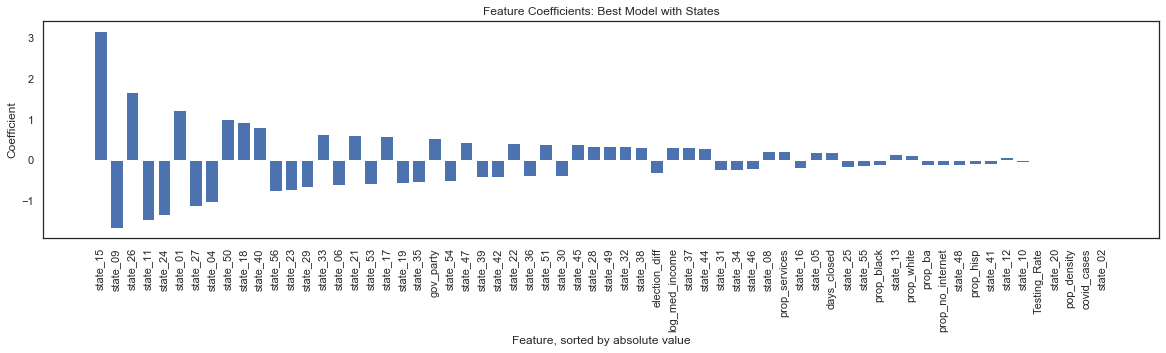

In [35]:
sns.set(rc={'figure.figsize':(20, 4)})
sns.set_style("white")

plt.bar(best_coeffs['feature'],best_coeffs['coefficient'])
plt.xticks(best_coeffs['feature'], rotation=90)
plt.title("Feature Coefficients: Best Model with States")
plt.xlabel("Feature, sorted by absolute value")
plt.ylabel("Coefficient")
plt.show()

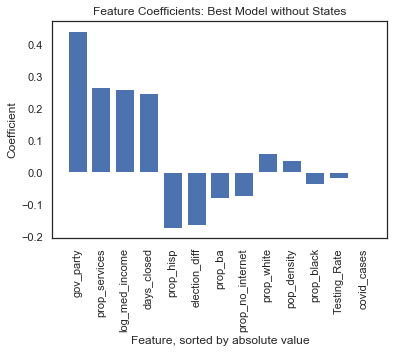

In [32]:
plt.bar(best_coeffs_wo['feature'], best_coeffs_wo['coefficient'])
plt.xticks(best_coeffs_wo['feature'], rotation=90)
plt.title("Feature Coefficients: Best Model without States")
plt.xlabel("Feature, sorted by absolute value")
plt.ylabel("Coefficient")
plt.show()